# Stratospheric Balance

We will have a look at stratospheric balance as function of time.

In [1]:
import sys, os, glob
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

In [2]:
import pylab as plt
import seaborn as sns
import cartopy.crs as ccrs
import importlib

sns.set_context('talk')

colors = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
ora = colors.pop(1)
colors.insert(2, ora)

myPara = {'figure.figsize': (14,7), 'lines.linewidth': 3, 'legend.frameon' : False,
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titleweight': 'bold',
          "axes.prop_cycle": plt.cycler(color=colors)
         }
                            
plt.rcParams.update( myPara )

import string

In [3]:
for pname in plt.rcParams:
    if 'linewidth' in pname:
        print( pname, plt.rcParams[pname])

axes.linewidth 1.875
boxplot.boxprops.linewidth 1.0
boxplot.capprops.linewidth 1.0
boxplot.flierprops.linewidth 1.0
boxplot.meanprops.linewidth 1.0
boxplot.medianprops.linewidth 1.0
boxplot.whiskerprops.linewidth 1.0
contour.linewidth None
grid.linewidth 1.5
hatch.linewidth 1.0
lines.linewidth 3.0
patch.linewidth 1.5


## Open Data

In [4]:
sys.path.append('../tools')

import importlib
import reader, plot, analysis
importlib.reload( reader )
importlib.reload( plot )
importlib.reload( analysis )
from analysis import ens_stat


In [5]:
input_dir = '~/data/wifi-aus/statistics/'

global_heating = xr.open_dataset( f'{input_dir}/stratospheric-heating-rates-by-time.nc')

* **prepare nudged data part**

In [6]:
global_heat_nudged = global_heating.sel(ensemble = 'nudged')
global_heat_nudged = global_heat_nudged.sel(mode = ['fire1.0', 'fire2.0', 'fire3.0', 'fire5.0']) - global_heat_nudged.sel(mode = 'fire0.0') 

In [7]:
global_heating_stats = ens_stat( global_heating )

## Plotting 

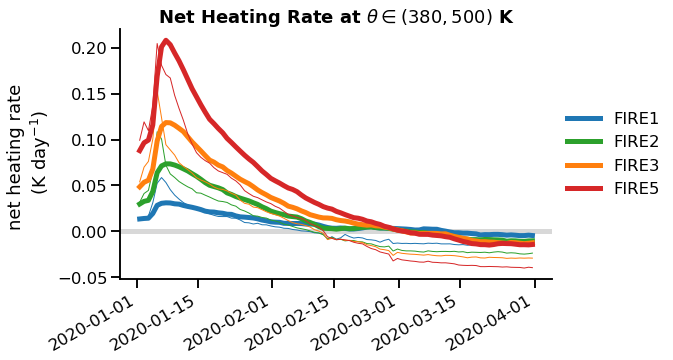

In [8]:
plt.figure( figsize = (10, 6))
plt.subplots_adjust( left = 0.2, bottom = 0.3, right = 0.8)
modes = global_heating_stats.mode
colors = ['C0', 'C1', 'C2', 'C3']
nlabels = plot.standardize_firenames( modes.data )
    
for i, mode in enumerate( modes ):
    gsn = global_heat_nudged.sel(mode = mode)
    gss = global_heating_stats.sel(mode = mode)
    
    gsn['dtdt_net'].plot( x = 'time', c = colors[i], lw = 1 ) #
    gss['dtdt_net'].sel(stats = 'mean').plot( x = 'time', c = colors[i], lw = 5, 
                                             label = nlabels[i] ) #

    
plt.legend(loc = 'center left', bbox_to_anchor=(1., 0.5,))
plt.axhline(0, color = 'gray', alpha = 0.3, zorder = 1, lw = 5 )
plt.xlabel('')
plt.ylabel('net heating rate \n (K day${}^{-1}$)')
plt.title(r'Net Heating Rate at $\theta\in(380,500)$ K')
plt.savefig('../pics/net-heating-decay-in-stratosphere.png', dpi = 600)

## Supplement 

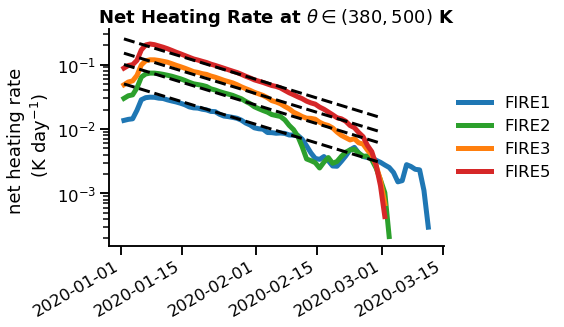

In [9]:
modes = global_heating_stats.mode
colors = ['C0', 'C1', 'C2', 'C3']

trel = (gss.time - gss.time.isel(time = 0)).astype(np.float32) / 1e9 / 3600 / 24.
decay_time = 21.

factors = np.array([1,2,3,5])
for offset in factors / 20.:
    fit = offset * np.exp(-trel/decay_time)
    fit = fit.sel(time = slice('2020-01', '2020-02'))
    fit.plot( x = 'time', color = 'k', ls = '--', zorder = 3)
    
for i, mode in enumerate( modes ):
    # gsn = global_heat_nudged.sel(mode = mode)
    gss = global_heating_stats.sel(mode = mode)
    gss = gss.where( gss > 0 )
    
    # gsn['dtdt_net'].plot( x = 'time', c = colors[i], lw = 1 ) #
    gss['dtdt_net'].sel(stats = 'mean').plot( x = 'time', c = colors[i], lw = 5, 
                                             label = nlabels[i] ) #
plt.legend(loc = 'center left', bbox_to_anchor=(1., 0.5,))
plt.axhline(0, color = 'gray', alpha = 0.3, zorder = 1, lw = 5 )
plt.xlabel('')
plt.ylabel('net heating rate \n (K day${}^{-1}$)')
plt.title(r'Net Heating Rate at $\theta\in(380,500)$ K')
plt.yscale('log')
# plt.ylim(1e-3, 3e-1)


    

(0.001, 0.3)

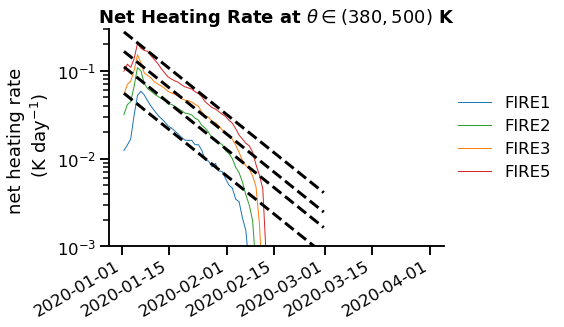

In [10]:
modes = global_heating_stats.mode
colors = ['C0', 'C1', 'C2', 'C3']

trel = (gss.time - gss.time.isel(time = 0)).astype(np.float32) / 1e9 / 3600 / 24.
decay_time = 14.

factors = np.array([1,2,3,5])
for offset in factors / 18.:
    fit = offset * np.exp(-trel/decay_time)
    fit = fit.sel(time = slice('2020-01', '2020-02'))
    fit.plot( x = 'time', color = 'k', ls = '--', zorder = 3)
    
for i, mode in enumerate( modes ):
    gsn = global_heat_nudged.sel(mode = mode)
    # gss = global_heating_stats.sel(mode = mode)
    #gsn = gsn.where( gss > 1e-4 )
    
    gsn['dtdt_net'].plot( x = 'time', c = colors[i], lw = 1, label = nlabels[i] )
    #gss['dtdt_net'].sel(stats = 'mean').plot( x = 'time', c = colors[i], lw = 5, 
                                          #
plt.legend(loc = 'center left', bbox_to_anchor=(1., 0.5,))
plt.axhline(0, color = 'gray', alpha = 0.3, zorder = 1, lw = 5 )
plt.xlabel('')
plt.ylabel('net heating rate \n (K day${}^{-1}$)')
plt.title(r'Net Heating Rate at $\theta\in(380,500)$ K')
plt.yscale('log')
plt.ylim(1e-3, 3e-1)


    

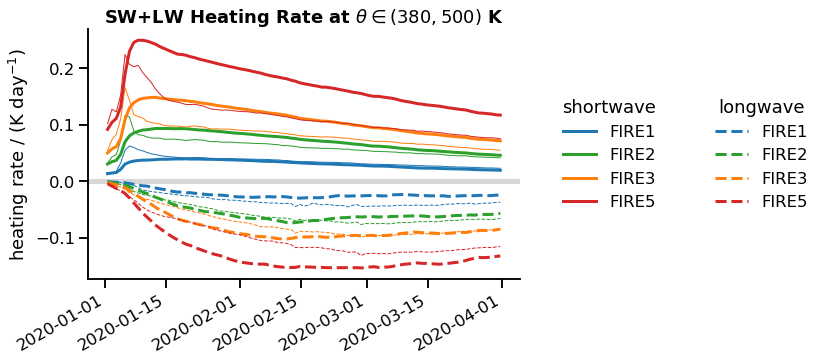

In [11]:
plt.figure( figsize = (10, 6))
plt.subplots_adjust( left = 0.2, bottom = 0.3, right = 0.8)
modes = list( global_heating_stats.mode.data )
colors = ['C0', 'C1', 'C2', 'C3']

swhandles = []

for i, mode in enumerate( modes ):
    gsn = global_heat_nudged.sel(mode = mode)
    gss = global_heating_stats.sel(mode = mode)
    
    gsn['dtdt_rheat_sw'].plot( x = 'time', c = colors[i], lw = 1 ) #
    p, = gss['dtdt_rheat_sw'].sel(stats = 'mean').plot( x = 'time', c = colors[i], lw = 3) #
    swhandles += [p, ]
    
legend1 = plt.legend(handles = swhandles, labels = nlabels,
           loc = 'center right', bbox_to_anchor=(1.35, 0.5,), title = 'shortwave')

lwhandles = []
for i, mode in enumerate( modes ):
    gsn = global_heat_nudged.sel(mode = mode)
    gss = global_heating_stats.sel(mode = mode)
    
    gsn['dtdt_rheat_lw'].plot(x = 'time', c = colors[i], 
                                                 lw = 1, ls = '--') #
    p, = gss['dtdt_rheat_lw'].sel(stats = 'mean').plot(x = 'time', c = colors[i], 
                                                  lw = 3, ls = '--', label = nlabels[i]) #

    lwhandles +=[ p, ]

legend2 = plt.legend(handles = lwhandles, labels = nlabels,
           loc = 'center right', bbox_to_anchor=(1.7, 0.5,), title = 'longwave')
plt.gca().add_artist(legend1)

#plt.legend(loc = 'center left', bbox_to_anchor=(1.33, 0.5,), title = 'longwave')
plt.axhline(0, color = 'gray', alpha = 0.3, zorder = 1, lw = 5 )
plt.xlabel('')
plt.ylabel('heating rate / (K day${}^{-1}$)')
plt.title(r'SW+LW Heating Rate at $\theta\in(380,500)$ K')
plt.savefig('../pics/sw-lw-heating-decay-in-stratosphere.png', dpi = 600)

**Take-away points:**

* after a month or two, the stratospheric adjustment lead to a new equilibrium state in which sw forcing is balanced by lw response